In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf # note that environment set up:  python=3.7 pytorch tensorflow-gpu=2.0

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import glob
import tqdm
from PIL import Image # Needed to load all *.tiff

In [2]:
# Load all tiff 
imgsize = 256 # resizing to something really small but will try to make this bigger later (3048)

#dataRoot='/project/hackathon/hackers03/shared/'
## \hackers03\shared\bgsub_20X_50K_all is where all the full .TIFF file is
## test case : X:\hackers03\hack039\test0
dataRoot='/project/hackathon/hackers03/shared/bgsub_20X_50K_all/'
dataOut='/project/hackathon/hackers03/hack039/OutputNPY/'

#brightListDir=glob.glob(dataRoot+'tiled_256_bgsub_20X_50K_all/'+'*bright*')
brightListDir=glob.glob(dataRoot+'*bright*')

RGB1ListDir=brightListDir.copy()
RGB2ListDir=brightListDir.copy()
RGB3ListDir=brightListDir.copy()
for l in range(len(RGB1ListDir)):
    RGB1ListDir[l]=RGB1ListDir[l].replace('brightfield','RGB_000000')
    RGB2ListDir[l]=RGB3ListDir[l].replace('brightfield','RGB_000001')
    RGB3ListDir[l]=RGB3ListDir[l].replace('brightfield','RGB_000002')


print(brightListDir[0])
print(RGB1ListDir[0])
print(RGB2ListDir[0])
print(RGB3ListDir[0])

br_dataTensor=np.zeros((len(brightListDir),imgsize,imgsize,3)) 
fl_dataTensor=np.zeros((len(brightListDir),imgsize,imgsize,3)) 
for l in range(len(brightListDir)):
    img=Image.open(brightListDir[l])
    img=img.resize((imgsize,imgsize))
    br_dataTensor[l,:,:,0]=np.array(img)
    
    img=Image.open(brightListDir[l])
    img=img.resize((imgsize,imgsize))
    br_dataTensor[l,:,:,0]=np.array(img)
    
    img=Image.open(brightListDir[l])
    img=img.resize((imgsize,imgsize))
    br_dataTensor[l,:,:,0]=np.array(img)

    img=Image.open(RGB1ListDir[l])
    img=img.resize((imgsize,imgsize))
    fl_dataTensor[l,:,:,0]=np.array(img)
    
    img=Image.open(RGB2ListDir[l])
    img=img.resize((imgsize,imgsize))
    fl_dataTensor[l,:,:,1]=np.array(img)
    
    img=Image.open(RGB3ListDir[l])
    img=img.resize((imgsize,imgsize))
    fl_dataTensor[l,:,:,2]=np.array(img)
    
    
np.save(dataOut+'br_full_tensor.npy',br_dataTensor)
np.save(dataOut+'fl_full_tensor.npy',fl_dataTensor)
print(fl_dataTensor.shape)
print(br_dataTensor.shape)
br_arr = br_dataTensor
fl_arr = fl_dataTensor
print(br_arr.shape)
print(fl_arr.shape)

/project/hackathon/hackers03/shared/bgsub_20X_50K_all/190709_20X_50K_0003_serie_25_brightfield.tif
/project/hackathon/hackers03/shared/bgsub_20X_50K_all/190709_20X_50K_0003_serie_25_RGB_000000.tif
/project/hackathon/hackers03/shared/bgsub_20X_50K_all/190709_20X_50K_0003_serie_25_RGB_000001.tif
/project/hackathon/hackers03/shared/bgsub_20X_50K_all/190709_20X_50K_0003_serie_25_RGB_000002.tif
(886, 256, 256, 3)
(886, 256, 256, 3)
(886, 256, 256, 3)
(886, 256, 256, 3)


(256, 256, 3)
(256, 256, 3)


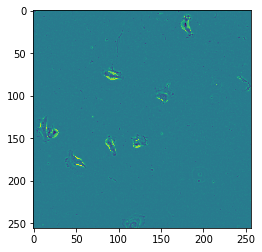

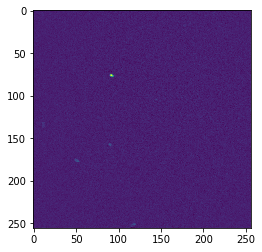

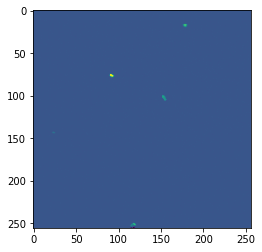

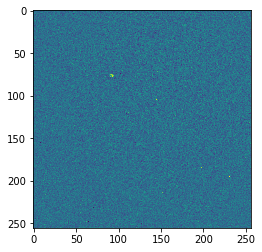

In [3]:
# Show just the first image patch in the sequence
br = br_dataTensor[0,:,:,0]
fl1 = fl_dataTensor[0,:,:,0]
fl2 = fl_dataTensor[0,:,:,1]
fl3 = fl_dataTensor[0,:,:,2]

plt.figure()
plt.imshow(br)

plt.figure()
plt.imshow(fl1)

plt.figure()
plt.imshow(fl2)

plt.figure()
plt.imshow(fl3)

# Show images with RBG channels collapsed
br = br_arr[0,:,:,:]
fl = fl_arr[0,:,:,:]
print(br.shape)
print(fl.shape)

In [4]:
def reshape_img(fl):
    fl_ = np.zeros((imgsize,imgsize,fl.shape[0]))
    for c in range(fl.shape[0]):
        fl_[:,:,c] = fl[c,:,:]
    return fl_

def reshape_img_arr(img):
    img_ = np.zeros((imgsize, imgsize, img.shape[1]))
    for c in range(img.shape[1]):
        img_[:,:,:,c] = img[:,c,:,:]
    return img_

def clean_3d(img):
    img_ = np.zeros_like(img)
    for c in range(img.shape[-1]):
        img_[:,:,c] = img[:,:,c] - img[:,:,c].min()
        img_[:,:,c] = img_[:,:,c]/img_[:,:,c].max()
    return img_

In [5]:
BUFFER_SIZE = 1000 
BATCH_SIZE = 3 # how many image in epoch
IMG_WIDTH = imgsize
IMG_HEIGHT = imgsize

In [6]:
def load_image_train():
    for i in range(br_arr.shape[0]):
        br_image = tf.cast(br_arr[i,:,:,:],tf.float32)
        fl_image  = tf.cast(fl_arr[i,:,:,:],tf.float32)
        br_image, fl_image = random_jitter(br_image, fl_image)
        br_image, fl_image = normalize(br_image, fl_image)
        yield br_image, fl_image

In [7]:
def resize(br_image, fl_image, height, width):
    br_image = tf.image.resize(br_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    fl_image = tf.image.resize(fl_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return br_image, fl_image

In [8]:
def random_crop(br_image, fl_image):
    stacked_image = tf.stack([br_image, fl_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [9]:
# normalizing the images to [-1, 1]
def normalize(br_image, fl_image):
    br_image = (br_image*2) - 1
    fl_image = (fl_image*2) - 1

    return br_image, fl_image

In [10]:
@tf.function()
def random_jitter(br_image, fl_image):
  # resizing to 314 x 314 x 3
  br_image, fl_image = resize(br_image, fl_image, 314, 314)

  # randomly cropping to 256 x 256 x 3
  br_image, fl_image = random_crop(br_image, fl_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    br_image = tf.image.flip_left_right(br_image)
    fl_image = tf.image.flip_left_right(fl_image)

  if tf.random.uniform(()) > 0.5:
    # random up-down mirror
    br_image = tf.image.flip_up_down(br_image)
    fl_image = tf.image.flip_up_down(fl_image)
    
  return br_image, fl_image

In [11]:
# As you can see in the images below
# that they are going through random jittering
# Random jittering as described in the paper is to
# 1. Resize an image to bigger height and width
# 2. Randomnly crop to the original size
# 3. Randomnly flip the image horizontally

#plt.figure(figsize=(6, 6))
#for i in range(4):
#  rj_br, rj_fl = random_jitter(br, fl)
#  plt.subplot(2, 2, i+1)
#  plt.imshow(rj_br)
#  plt.axis('off')
#plt.show()

In [12]:
train_dataset = tf.data.Dataset.from_generator(load_image_train, (tf.float32, tf.float32))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [13]:
OUTPUT_CHANNELS = 3

In [14]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [15]:
tf.keras.backend.set_floatx('float32')

In [16]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(br, 0))
print (down_result.shape)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(1, 128, 128, 3)


In [17]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [18]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [19]:
def Generator():
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None,None,3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


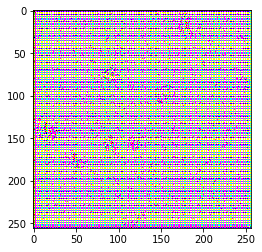

In [20]:
generator = Generator()

gen_output = generator(br[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...],cmap='gray')

In [21]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='br_image')
  tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



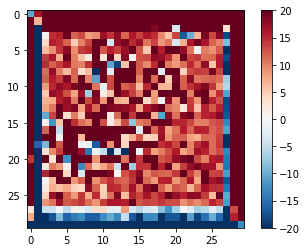

In [22]:
discriminator = Discriminator()
disc_out = discriminator([br[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [23]:
LAMBDA = 100

In [24]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [26]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [28]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [29]:
EPOCHS = 26

In [30]:
def generate_images(model, test_input, tar, epoch):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig("gen_images/epoch{}.png".format(epoch))
  plt.show()

In [31]:
@tf.function
def train_step(br_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(br_image, training=True)

    disc_real_output = discriminator([br_image, target], training=True)
    disc_generated_output = discriminator([br_image, gen_output], training=True)

    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [32]:
def fit(train_ds, epochs):
  for epoch in tqdm.tqdm(range(epochs)):

    # Train
    for br_image, target in train_ds:
      train_step(br_image, target)

    clear_output(wait=True)
    
    # saving (checkpoint) the model every 20 epochs
    if (epoch) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      for example_input, example_target in train_ds.take(1):
        generate_images(generator, example_input, example_target, epoch)
        plt.savefig('gen_images/epoch{}.png'.format(epoch+1))


In [33]:
!mkdir gen_images

mkdir: cannot create directory 'gen_images': File exists


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

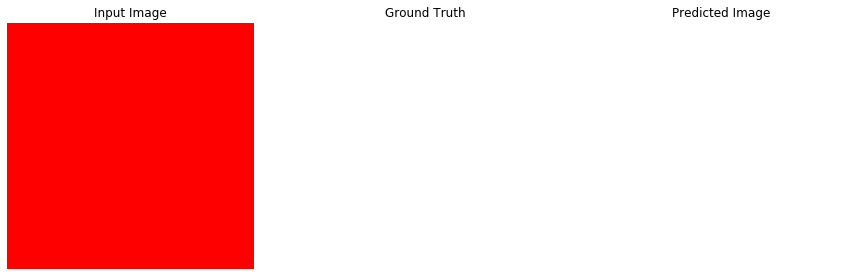

100%|██████████| 26/26 [15:48<00:00, 36.47s/it]


<Figure size 432x288 with 0 Axes>

In [34]:
fit(train_dataset, EPOCHS)

In [35]:
!nvidia-smi

Sun Nov 10 13:04:41 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:02:00.0 Off |                    0 |
| N/A   45C    P0    41W / 250W |  15755MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:82:00.0 Off |                    0 |
| N/A   71C    P0   182W / 250W |  15740MiB / 16280MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
        